In [ ]:
! pip install rasterio

In [ ]:
! pip install geopandas

In [3]:
import scipy
import sys
import numpy as np
from scipy import ndimage
from osgeo import gdal
from osgeo.gdalconst import *
import os
import glob
import rasterio as rio
from osgeo import gdal_array

In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
from holoviews import dim, opts
from matplotlib import cm
from matplotlib import colors

%matplotlib inline

In [5]:
import xarray as xr
import pandas as pd
import geopandas as gpd
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
from time import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# import specific libraries for NDCI analysis
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm, kurtosis
from scipy.signal import find_peaks
from scipy.signal import argrelmin

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
print(os.popen('ls /content/drive/MyDrive/BurkinaFaso').read())

cm_20190112.cpg
cm_20190112.dbf
cm_20190112.fix
cm_20190112.prj
cm_20190112.shp
cm_20190112.shx
cm_20190412.cpg
cm_20190412.dbf
cm_20190412.fix
cm_20190412.prj
cm_20190412.shp
cm_20190412.shx
cm_20190924.cpg
cm_20190924.dbf
cm_20190924.fix
cm_20190924.prj
cm_20190924.shp
cm_20190924.shx
land_20190112.cpg
land_20190112.dbf
land_20190112.fix
land_20190112.prj
land_20190112.shp
land_20190112.shx
land_20190412.cpg
land_20190412.dbf
land_20190412.fix
land_20190412.prj
land_20190412.shp
land_20190412.shx
land_20190924.cpg
land_20190924.dbf
land_20190924.fix
land_20190924.prj
land_20190924.shp
land_20190924.shx
S2_SCL_20190112.tif
S2_SCL_20190412.tif
S2_SCL_20190924.tif
S2_testscene_20190112.tif
S2_testscene_20190412.tif
S2_testscene_20190924.tif



In [8]:
# Open the new tiff file

filepath = r"/content/drive/MyDrive/BurkinaFaso/S2_testscene_20190412.tif"

# Open the file:
dataset = gdal.Open(filepath)
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc2272dcfc0> >

In [9]:
dataset.GetRasterBand(1).DataType

2

In [10]:
dataset.GetRasterBand(1).ReadAsArray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

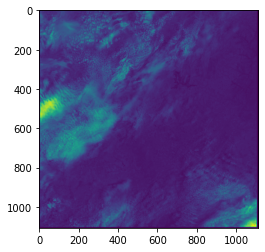

In [11]:
plt.imshow(dataset.GetRasterBand(1).ReadAsArray())

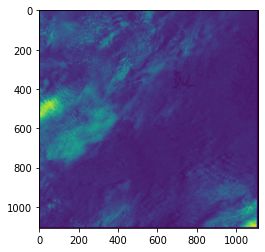

In [ ]:
plt.imshow(dataset.GetRasterBand(2).ReadAsArray())

In [12]:
# Put the gdal dataset into numpy array for visualization

# check data type
image_datatype = dataset.GetRasterBand(1).DataType

# set up an empty data array
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset
for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()

In [13]:
image

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [14]:
image.shape

(1106, 1114, 12)

In [17]:
newMask = ssmask(dataset)

newMask

Start building arrays
Blue Band:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
01/10 Start snow classification
02/10 Initialize snow map array
03/10 Calculating Spectral Indices
04/10 Scene classification


ValueError: ignored

In [ ]:
newMask.shape

(1106, 1114)

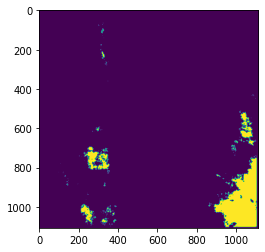

In [ ]:
plt.imshow(newMask)

In [ ]:
# Open the new tiff file

filepath = r"/content/drive/MyDrive/BurkinaFaso/S2_testscene_20190112.tif"

# Open the file:
dataset = gdal.Open(filepath)
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa3d43ca300> >

In [ ]:
dataset.GetRasterBand(1).DataType

2

In [ ]:
dataset.GetRasterBand(1).ReadAsArray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

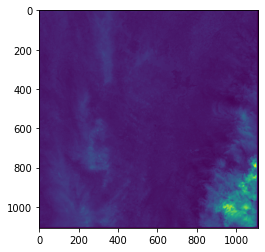

In [ ]:
plt.imshow(dataset.GetRasterBand(1).ReadAsArray())

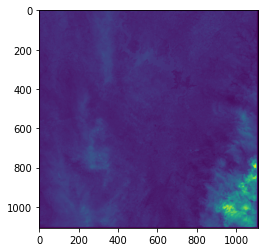

In [ ]:
plt.imshow(dataset.GetRasterBand(2).ReadAsArray())

In [ ]:
# Put the gdal dataset into numpy array for visualization

# check data type
image_datatype = dataset.GetRasterBand(1).DataType

# set up an empty data array
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset
for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()

In [ ]:
image

In [ ]:
image.shape

(1106, 1114, 12)

In [ ]:
newMask = ssmask(dataset)

newMask

In [ ]:
newMask.shape

(1106, 1114)

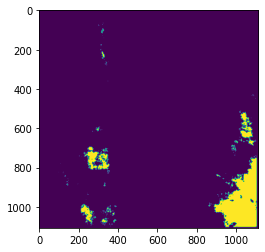

In [ ]:
plt.imshow(newMask)

In [ ]:
scl_path = r"/content/drive/MyDrive/BurkinaFaso/S2_SCL_20190112.tif"

# Import the original cloud mask
scl_ds = rio.open(scl_path)

# Convert dataset into a 2D numpy array
scl_mat = np.zeros(scl_ds.shape, dtype=rio.float32)
scl_mat = scl_ds.read(1)

# Matrix value
scl_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

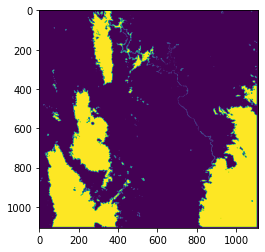

In [ ]:
plt.imshow(scl_mat)

In [16]:
def ssmask(S2_data):
    """
    Sentinel 2 classification of cloud mask.
    Description
    ----------
    Generating cloud classification used in Burkina Faso.
    Parameters
    ----------
    S2_data: osgeo.gdal.Dataset
        Landsat-8 dataset with blue, green, red, nir, swir, and thermal bands
    Returns
    -------
    CM_data: osgeo.gdal.Dataset
        dataset with binary cloud mask, where cloud == 1 and clear == 0
    """
    print("Start building arrays")
    t = np.float32
    
    # Read Bands
    blue = S2_data.GetRasterBand(2).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    green = S2_data.GetRasterBand(3).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    red = S2_data.GetRasterBand(4).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    rededge3 = S2_data.GetRasterBand(7).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    nir = S2_data.GetRasterBand(8).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    vapour = S2_data.GetRasterBand(9).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    swir1 = S2_data.GetRasterBand(11).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    
    # Convert formats
    b = blue.astype(t)
    g = green.astype(t)
    e = rededge3.astype(t)
    r = red.astype(t)
    n = nir.astype(t)
    v = vapour.astype(t)
    s = swir1.astype(t)
    
    # Apply scale factors
    b = b * 0.00001
    g = g * 0.00001
    e = e * 0.00001
    r = r * 0.00001
    n = n * 0.00001
    s = s * 0.00001

    print("Blue Band: ", b)
    
    np.seterr(invalid='ignore')
    strength = 0.4
    
    print("01/10 Start snow classification")

    print("02/10 Initialize snow map array")
    CM = np.zeros(b.shape)

    print("03/10 Calculating Spectral Indices")
    ndsi = (g - s) / (g + s)
    ndvi = (n - r) / (n + r)
    ndci = (b - n) / (b + n)
    
    ndci_hist = ndci[~np.isnan(ndci)]
    
    # Store statistics
    NDCI_min = np.quantile(ndci_hist,0.05) # minimum NDCI allowing 5% outliners
    NDCI_max = np.quantile(ndci_hist,0.95) # maximum NDCI allowing 5% outliners
    NDCI_std = np.std(ndci_hist) # NDCI standard deviation
    vapour_median = np.median(v[~np.isnan(v)]) # median for water vapour
    NDCI_skew = skew(ndci_hist) # NDCI skewness: how far is NDCI away from normal distribution
    NDCI_median = np.median(ndci_hist) # NDCI median
    NDCI_kur = kurtosis(ndci_hist) # NDCI kurtosis: depends on the shape of distribution
    
    # calculating the peak of NDCI histogram and detect number of peaks
    counts, bin_edges = np.histogram(ndci_hist) # get frequency count of every NDCI range groups
    peaks,_ = find_peaks(counts, prominence=len(ndci_hist)/50) # get all peaks (between increasing and decreasing counts)
    npeak = len(peaks.flatten()) # get the number of peaks
    
    print("04/10 Scene classification")
    
    # Classified Scene: All Clouds
    if NDCI_min >= -0.1:
        CM = np.zeros(b.shape)
        
    # Classified Scene: Mostly clouds
    elif NDCI_min < -0.1 and NDCI_min >= -0.3:
        if bin_edges[peaks[0]] < -0.3:
            thres = bin_edges[peaks[0]]
        else:
            thres = -0.3
        CM[ndci > thres] = 1 
    
    # Classified Scene: Mostly clouds
    
    # other condition for scene to be classify as mostly clouds: lower NDCI but histogram highly skewed towards high values
    # kurtosis values restricted to peak to be sharp for cloudy conditions
    # if clouds are dominant in scene, there should be only one peak in the histogram
    
    elif NDCI_min < -0.3 and NDCI_median > -0.35 and NDCI_kur > -1 and NDCI_skew < 0 and npeak == 1:
        if bin_edges[peaks[0]] < -0.3:
            thres = bin_edges[peaks[0]]
        else:
            thres = -0.3
        CM[ndci > thres] = 1
    
    # Classified Scene: Clear sky
    
    # either low NDCI for all pixels or low median with really sharp peak for sunny conditions
    
    elif NDCI_max < -0.3 or (NDCI_kur > 1.5 and NDCI_median < -0.4):
        print(v)
        CM[(ndci > -0.3) & (v > vapour_median*1.1)] = 1
    
    # Classified Scene: Partly clouds
    else:
        counts, bin_edges = np.histogram(ndci, bins=30)
        if npeak <= 1:
            peak = np.argmax(counts)
            mode = (bin_edges[peak] + bin_edges[peak+1])/2 # check dominant NDCI value

            par = stats.percentileofscore(ndci, mode) # get quantile for dominant NDCI value

            factor = 1 - NDCI_std # define fector to adjust NDCI threshold 
            # the more variant NDCI, the more conservative to define the end of NDCI cluster
            adj_factor = (100 - par)*(factor/50) # tune the value to make sure percentile lies within 0% and 100%
            refine = (par + adj_factor)/100
            NDCI_thres = np.quantile(ndci,refine) # calculate the NDCI threshold

        else:
            min_indices = argrelmin(counts)[0]
            ind_min = np.argmin(counts[min_indices])
            ind_hist = min_indices[ind_min]
            NDCI_thres = (bin_edges[ind_hist] + (-0.4))/2
            strength = 0.5
        
        # default values false for neg: indicate negative strength
        neg = False
        
        # adjust strength depends on NDCI skewness (the proxy for cloud proportion)
        # to make sure consistent masking independent of weather condition
        if NDCI_skew > 1:
            strength = strength + 0.3
            if strength > 1:
                strength = 1 # make sure strength lies within 0 and 1
        elif NDCI_skew > 0 and NDCI_skew < 0.2: # less strength when there are few clouds
            strength = strength - 0.2
            if strength < 0:
                neg = True
                negative_adj = strength
                strength = 0
        elif NDCI_skew < -0.4: # increase strength when there are lots of clouds
            strength = strength + 0.3
            if strength > 1:
                strength = 1
                
        # apply strength to adjust the NDCI threshold
        if NDCI_thres <= 0:
            NDCI_thres_adjust = (NDCI_thres - 1) * strength * 2
            NDCI_thres_adjust = NDCI_thres_adjust + (strength * 2)
        elif NDCI_thres > 0:
            NDCI_thres_adjust = (NDCI_thres + 1) * strength * -2
            NDCI_thres_adjust = NDCI_thres_adjust - (strength * -2)
        if neg == True:
            NDCI_thres_adjust = NDCI_thres_adjust + negative_adj/5 

        # use NDCI sknewness as the proxy for cloudyness of the scene
        # which is used for second condition depending on the water vapour value
        
        if NDCI_skew >= -0.5 and NDCI_skew < -0.3:
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.45)) & (ndvi < 0.2)] = 1
            
        elif NDCI_skew < -0.5: # lower water vapour threshold for relatively cloudy condition
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.3)) & (ndvi < 0.2)] = 1
 
        else: # higher water vapour threshold for relatively less cloudy condition
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.5)) & (ndvi < 0.2)] = 1
        
    sm_CM = ndimage.uniform_filter(CM, size=2, mode='nearest')
    new_CM = (sm_CM == 1)
    new_CM = new_CM.astype(int)

    return new_CM